# Load Libraries for Analysis

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import os

# graphing settings
plt.rcParams.update({
'figure.figsize': (6, 6),
'figure.dpi': 300,
'axes.spines.top': False,
'axes.spines.right': False,
'axes.linewidth': 1.0,
'axes.prop_cycle': plt.cycler(color='kbrgymc'),
'font.family': 'Helvetica Neue',
'font.size': 12,
'legend.frameon': 'false',
'xtick.labelsize': 16,
'ytick.labelsize': 16,
})

# Constants

In [2]:
DATA_DIR = "data/experiment2"
REPS = 30
DELAYS = [5, 10, 20, 30, 40, 50, 60, 70, 80]
LL_MAG = 15

# Equations

In [3]:
def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(b * (x - c))))+d

def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Note: A must be defined before using these functions
def mazur(x, k):
    return A / (1 + k*x)

def rachlin(x, k, s):
    return A / (1 + k*x**s)

def myerson_green(x, k, s):
    return A / (1 + k*x)**s

# Functions

In [4]:
def estimate_indifference_point(mags: np.ndarray, props: np.ndarray) -> float:
    """
    Estimates the indifference point given smaller sooner magnitudes and proportion of choices for the smaller sooner option
    """
    params, _ = curve_fit(sigmoid, mags, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    estimation_x = np.linspace(min(mags), max(mags), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_pt = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]

    return indiff_pt

def min_max_transform(indiff_pts: np.ndarray) -> np.ndarray:
    """
    Transforms the indifference points by reversing the scale
    """
    return ((min(indiff_pts) + max(indiff_pts)) - indiff_pts) 

# Load the Data

In [6]:
dfs = []

files = [f for f in os.listdir(DATA_DIR) if f.endswith(".xlsx")]

for file in files:
    for rep in range(1, REPS+1):
        df = pd.read_excel(f"{DATA_DIR}/{file}", sheet_name=f"Repetition {rep}")
        df["Rep"] = rep
        df["File"] = file
        df['SSMag'] = int(file.split('.')[0].replace('ssmag', ''))
        df['LL Delay'] = df['Sched'].apply(lambda x: int(DELAYS[x-1]))

        dfs.append(df)

df = pd.concat(dfs)

df.head()

,Sched,P1,R1,B1,P2,R2,B2,Rep,File,SSMag,LL Delay
0,1,0,0,0,0,78,305,1,ssmag95.xlsx,95,5
1,1,0,0,0,0,68,340,1,ssmag95.xlsx,95,5
2,1,0,0,0,0,101,359,1,ssmag95.xlsx,95,5
3,1,0,1,1,0,71,291,1,ssmag95.xlsx,95,5
4,1,0,0,0,0,76,356,1,ssmag95.xlsx,95,5


# Clean the Data

In [9]:
# remove the first row (500 gens) for each file, for each rep, for each sched
clean_df = df.groupby(["File", "Rep", "Sched"]).apply(lambda x: x.iloc[1:]).reset_index(drop=True)

clean_df.head()

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_7180/652372700.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_df = df.groupby(["File", "Rep", "Sched"]).apply(lambda x: x.iloc[1:]).reset_index(drop=True)


,Sched,P1,R1,B1,P2,R2,B2,Rep,File,SSMag,LL Delay
0,1,0,0,0,0,80,357,1,ssmag115.xlsx,115,5
1,1,0,0,0,0,89,359,1,ssmag115.xlsx,115,5
2,1,0,0,0,0,89,351,1,ssmag115.xlsx,115,5
3,1,0,0,0,0,91,377,1,ssmag115.xlsx,115,5
4,1,0,0,0,0,82,359,1,ssmag115.xlsx,115,5
...,...,...,...,...,...,...,...,...,...,...,...
107995,9,0,45,56,0,2,27,30,ssmag95.xlsx,95,80
107996,9,0,123,154,0,1,2,30,ssmag95.xlsx,95,80
107997,9,0,115,134,0,0,0,30,ssmag95.xlsx,95,80
107998,9,0,25,30,0,8,125,30,ssmag95.xlsx,95,80


# Individual AO Data

In [11]:
ind_ao_df = clean_df.groupby(["File", "Rep", "Sched"]).mean().reset_index()

ind_ao_df["PropSS"] = ind_ao_df["B1"] / (ind_ao_df["B1"] + ind_ao_df["B2"])

ind_ao_df

,File,Rep,Sched,P1,R1,B1,P2,R2,B2,SSMag,LL Delay,PropSS
0,ssmag115.xlsx,1,1,0.0,0.000,0.000,0.0,82.250,348.875,115.0,5.0,0.000000
1,ssmag115.xlsx,1,2,0.0,37.000,42.575,0.0,27.650,180.575,115.0,10.0,0.190791
2,ssmag115.xlsx,1,3,0.0,41.100,48.950,0.0,13.700,133.050,115.0,20.0,0.268956
3,ssmag115.xlsx,1,4,0.0,88.025,104.300,0.0,3.025,32.325,115.0,30.0,0.763403
4,ssmag115.xlsx,1,5,0.0,90.700,106.825,0.0,2.325,30.800,115.0,40.0,0.776203
...,...,...,...,...,...,...,...,...,...,...,...,...
2695,ssmag95.xlsx,30,5,0.0,93.100,111.500,0.0,2.425,30.175,95.0,40.0,0.787013
2696,ssmag95.xlsx,30,6,0.0,99.550,119.400,0.0,1.875,23.700,95.0,50.0,0.834382
2697,ssmag95.xlsx,30,7,0.0,105.675,126.175,0.0,1.350,18.900,95.0,60.0,0.869723
2698,ssmag95.xlsx,30,8,0.0,111.150,132.725,0.0,0.775,11.850,95.0,70.0,0.918036


# Average Data

In [15]:
avg_df = ind_ao_df.groupby(["File", "Sched"]).agg(["mean", "std"]).reset_index()

avg_df

File Sched   Rep             P1               R1             \
                         mean       std mean  std        mean        std   
0   ssmag115.xlsx     1  15.5  8.803408  0.0  0.0    4.964167   9.279438   
1   ssmag115.xlsx     2  15.5  8.803408  0.0  0.0   14.970000   9.807003   
2   ssmag115.xlsx     3  15.5  8.803408  0.0  0.0   49.225833  12.280310   
3   ssmag115.xlsx     4  15.5  8.803408  0.0  0.0   65.280000  11.810748   
4   ssmag115.xlsx     5  15.5  8.803408  0.0  0.0   75.471667   9.863833   
..            ...   ...   ...       ...  ...  ...         ...        ...   
85   ssmag95.xlsx     5  15.5  8.803408  0.0  0.0   95.549167  11.210378   
86   ssmag95.xlsx     6  15.5  8.803408  0.0  0.0   99.528333   7.496254   
87   ssmag95.xlsx     7  15.5  8.803408  0.0  0.0  100.811667   8.646326   
88   ssmag95.xlsx     8  15.5  8.803408  0.0  0.0  104.436667   7.241376   
89   ssmag95.xlsx     9  15.5  8.803408  0.0  0.0  107.027500   7.149253   

            B1             ...         R2                    B2             \
          mean        std  ...       mean       std        mean        std   
0     5.816667  10.841490  ...  78.028333  7.223190  328.405833  30.415853   
1    17.517500  11.540682  ...  36.141667  3.681403  239.885000  25.450245   
2    57.945833  14.391649  ...  11.673333  2.558909  113.275833  24.907400   
3    77.057500  14.106308  ...   5.861667  1.524268   67.622500  17.961218   
4    88.890833  11.676054  ...   3.561667  0.943803   45.317500  12.643472   
..         ...        ...  ...        ...       ...         ...        ...   
85  114.684167  13.399758  ...   2.511667  1.022879   32.169167  13.121348   
86  119.275833   8.924498  ...   1.830000  0.619072   24.822500   8.878319   
87  120.975833  10.563465  ...   1.500833  0.629535   21.384167   9.301449   
88  125.193333   8.833571  ...   1.142500  0.406634   16.922500   6.902168   
89  128.340833   8.657557  ...   0.936667  0.374208   14.238333   6.001357   

    SSMag      LL Delay         PropSS            
     mean  std     mean  std      mean       std  
0   115.0  0.0      5.0  0.0  0.019590  0.039101  
1   115.0  0.0     10.0  0.0  0.070641  0.050321  
2   115.0  0.0     20.0  0.0  0.344684  0.106254  
3   115.0  0.0     30.0  0.0  0.535486  0.109013  
4   115.0  0.0     40.0  0.0  0.663059  0.090851  
..    ...  ...      ...  ...       ...       ...  
85   95.0  0.0     40.0  0.0  0.780861  0.089744  
86   95.0  0.0     50.0  0.0  0.827868  0.061117  
87   95.0  0.0     60.0  0.0  0.849386  0.066164  
88   95.0  0.0     70.0  0.0  0.880421  0.049607  
89   95.0  0.0     80.0  0.0  0.899526  0.043915  

[90 rows x 22 columns]

# Analysis

## Estimatating Indifference Points for Each AO

In [16]:
ao_indiff_pts_dict = {
    "Rep": [],
    "LL Delay": [],
    "Indifference Point": [],
    "Transformed Indifference Point": []
}

for rep in ind_ao_df["Rep"].unique():
    indiff_pts = []
    for delay in ind_ao_df["LL Delay"].unique():
        # skip ll delay 5
        if delay == 5:
            continue

        df = ind_ao_df[(ind_ao_df["Rep"] == rep) & (ind_ao_df["LL Delay"] == delay)]

        mags = df["SSMag"].values
        props = df["PropSS"].values

        indiff_pts.append(estimate_indifference_point(mags, props))

        ao_indiff_pts_dict["Rep"].append(rep)
        ao_indiff_pts_dict["LL Delay"].append(delay)

    transformed_indiff_pts = min_max_transform(np.array(indiff_pts))

    ao_indiff_pts_dict["Indifference Point"].extend(indiff_pts)
    ao_indiff_pts_dict["Transformed Indifference Point"].extend(transformed_indiff_pts)

ao_indiff_pts_df = pd.DataFrame(ao_indiff_pts_dict)

ao_indiff_pts_df

,Rep,LL Delay,Indifference Point,Transformed Indifference Point
0,1,10.0,53.955396,150.437044
1,1,20.0,98.847885,105.544554
2,1,30.0,123.138814,81.253625
3,1,40.0,139.384438,65.008001
4,1,50.0,148.204820,56.187619
...,...,...,...,...
235,30,40.0,137.679268,84.601960
236,30,50.0,146.329133,75.952095
237,30,60.0,136.160116,86.121112
238,30,70.0,148.344334,73.936894


## Fitting Discounting Equations for Each AO

In [19]:
ao_fit_dict = {
    "Rep": [],
    "Mazur k": [],
    "Mazur R^2": [],
    "Mazur Sy_x": [],
    "Myerson & Green k": [],
    "Myerson & Green s": [],
    "Myerson & Green R^2": [],
    "Myerson & Green Sy_x": [],
    "Rachlin k": [],
    "Rachlin s": [],
    "Rachlin R^2": [],
    "Rachlin Sy_x": []
}

for rep in ao_indiff_pts_df["Rep"].unique():
    df = ao_indiff_pts_df[ao_indiff_pts_df["Rep"] == rep]

    x = df["LL Delay"].values
    y = df["Transformed Indifference Point"].values
    A = min(y) + max(y) - LL_MAG # set A for each AO

    ss_tot = np.sum((y - np.mean(y))**2)

    # Mazur
    mazur_params, mazur_cov = curve_fit(mazur, x, y, p0=[0.05], maxfev=10000)

    mazur_res = y - mazur(x, *mazur_params)
    mazur_ss_res = np.sum(mazur_res**2)
    mazur_r2 = 1 - (mazur_ss_res/ss_tot)

    # Myerson & Green
    myerson_green_params, myerson_green_cov = curve_fit(myerson_green, x, y, p0=[0.05, 1], maxfev=10000)

    myerson_green_res = y - myerson_green(x, *myerson_green_params)
    myerson_green_ss_res = np.sum(myerson_green_res**2)
    myerson_green_r2 = 1 - (myerson_green_ss_res/ss_tot)

    # Rachlin
    rachlin_params, rachlin_cov = curve_fit(rachlin, x, y, p0=[0.05, 1], maxfev=10000)

    rachlin_res = y - rachlin(x, *rachlin_params)
    rachlin_ss_res = np.sum(rachlin_res**2)
    rachlin_r2 = 1 - (rachlin_ss_res/ss_tot)

    ao_fit_dict["Rep"].append(rep)

    ao_fit_dict["Mazur k"].append(mazur_params[0])
    ao_fit_dict["Mazur R^2"].append(mazur_r2)
    ao_fit_dict["Mazur Sy_x"].append(np.sqrt(mazur_ss_res/(len(y) - 1)))

    ao_fit_dict["Myerson & Green k"].append(myerson_green_params[0])
    ao_fit_dict["Myerson & Green s"].append(myerson_green_params[1])
    ao_fit_dict["Myerson & Green R^2"].append(myerson_green_r2)
    ao_fit_dict["Myerson & Green Sy_x"].append(np.sqrt(myerson_green_ss_res/(len(y) - 1)))

    ao_fit_dict["Rachlin k"].append(rachlin_params[0])
    ao_fit_dict["Rachlin s"].append(rachlin_params[1])
    ao_fit_dict["Rachlin R^2"].append(rachlin_r2)
    ao_fit_dict["Rachlin Sy_x"].append(np.sqrt(rachlin_ss_res/(len(y) - 1)))
                                       
ao_fit_dict["Rep"].extend(["Mean", "SD"])
# calculate mean and std for each fit parameter
ao_fit_dict["Mazur k"].extend([np.mean(ao_fit_dict["Mazur k"]), np.std(ao_fit_dict["Mazur k"])])
ao_fit_dict["Mazur R^2"].extend([np.mean(ao_fit_dict["Mazur R^2"]), np.std(ao_fit_dict["Mazur R^2"])])
ao_fit_dict["Mazur Sy_x"].extend([np.mean(ao_fit_dict["Mazur Sy_x"]), np.std(ao_fit_dict["Mazur Sy_x"])])

ao_fit_dict["Myerson & Green k"].extend([np.mean(ao_fit_dict["Myerson & Green k"]), np.std(ao_fit_dict["Myerson & Green k"])])
ao_fit_dict["Myerson & Green s"].extend([np.mean(ao_fit_dict["Myerson & Green s"]), np.std(ao_fit_dict["Myerson & Green s"])])
ao_fit_dict["Myerson & Green R^2"].extend([np.mean(ao_fit_dict["Myerson & Green R^2"]), np.std(ao_fit_dict["Myerson & Green R^2"])])
ao_fit_dict["Myerson & Green Sy_x"].extend([np.mean(ao_fit_dict["Myerson & Green Sy_x"]), np.std(ao_fit_dict["Myerson & Green Sy_x"])])

ao_fit_dict["Rachlin k"].extend([np.mean(ao_fit_dict["Rachlin k"]), np.std(ao_fit_dict["Rachlin k"])])
ao_fit_dict["Rachlin s"].extend([np.mean(ao_fit_dict["Rachlin s"]), np.std(ao_fit_dict["Rachlin s"])])
ao_fit_dict["Rachlin R^2"].extend([np.mean(ao_fit_dict["Rachlin R^2"]), np.std(ao_fit_dict["Rachlin R^2"])])
ao_fit_dict["Rachlin Sy_x"].extend([np.mean(ao_fit_dict["Rachlin Sy_x"]), np.std(ao_fit_dict["Rachlin Sy_x"])])


ao_fit_df = pd.DataFrame(ao_fit_dict)

ao_fit_df

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_7180/252976555.py:15: RuntimeWarning: invalid value encountered in power
  return A / (1 + k*x)**s


,Rep,Mazur k,Mazur R^2,Mazur Sy_x,Myerson & Green k,Myerson & Green s,Myerson & Green R^2,Myerson & Green Sy_x,Rachlin k,Rachlin s,Rachlin R^2,Rachlin Sy_x
0,1,0.038448,0.934971,8.575629,0.038561,0.998067,0.934972,8.575606,0.031948,1.052135,0.936773,8.455980
1,2,0.033551,0.902356,11.499106,0.024118,1.258936,0.905458,11.314962,0.020988,1.130066,0.911476,10.948945
2,3,0.029749,0.861411,10.989318,0.093353,0.507305,0.933698,7.600971,0.070754,0.763249,0.930512,7.781458
3,4,0.028315,0.953301,7.624178,0.030277,0.955329,0.953437,7.613078,0.028625,0.997037,0.953308,7.623664
4,5,0.027614,0.813205,12.083077,0.101242,0.463933,0.909186,8.425006,0.073344,0.734360,0.903122,8.701763
5,6,0.028804,0.953089,6.890555,0.044950,0.748799,0.960572,6.317103,0.041073,0.903556,0.961217,6.265183
6,7,0.032470,0.921474,8.166490,0.077878,0.588784,0.963846,5.541220,0.061507,0.823685,0.955816,6.125773
7,8,0.028574,0.934405,7.306711,0.070308,0.574271,0.974014,4.598880,0.056859,0.812819,0.973492,4.644919
8,9,0.024512,0.667496,14.388499,0.159237,0.349038,0.896369,8.032695,0.096293,0.631561,0.896253,8.037202
9,10,0.029553,0.803951,11.583703,0.127451,0.433676,0.947485,5.995219,0.088440,0.700127,0.938351,6.495753


# Graphs

## Indifference Point Estimaiton for One AO

In [20]:
# find the rep with the R^2 closest to the mean R^2 for myerson-green

myerson_green_r_squared_vals = ao_fit_df[(ao_fit_df['Rep'] != 'Mean') & (ao_fit_df['Rep'] != 'SD')]['Myerson & Green R^2'].values

mean = np.mean(myerson_green_r_squared_vals)

# find the value closest to the mean
closest = min(myerson_green_r_squared_vals, key=lambda x: abs(x - mean))

ao_fit_df[(ao_fit_df['Rep'] != 'Mean') & (ao_fit_df['Rep'] != 'SD')][ao_fit_df['Myerson & Green R^2'] == closest]

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_7180/4101744649.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ao_fit_df[(ao_fit_df['Rep'] != 'Mean') & (ao_fit_df['Rep'] != 'SD')][ao_fit_df['Myerson & Green R^2'] == closest]


,Rep,Mazur k,Mazur R^2,Mazur Sy_x,Myerson & Green k,Myerson & Green s,Myerson & Green R^2,Myerson & Green Sy_x,Rachlin k,Rachlin s,Rachlin R^2,Rachlin Sy_x
18,19,0.036719,0.900548,12.957397,0.005254,4.699181,0.946069,9.541777,0.008467,1.409477,0.961363,8.076327


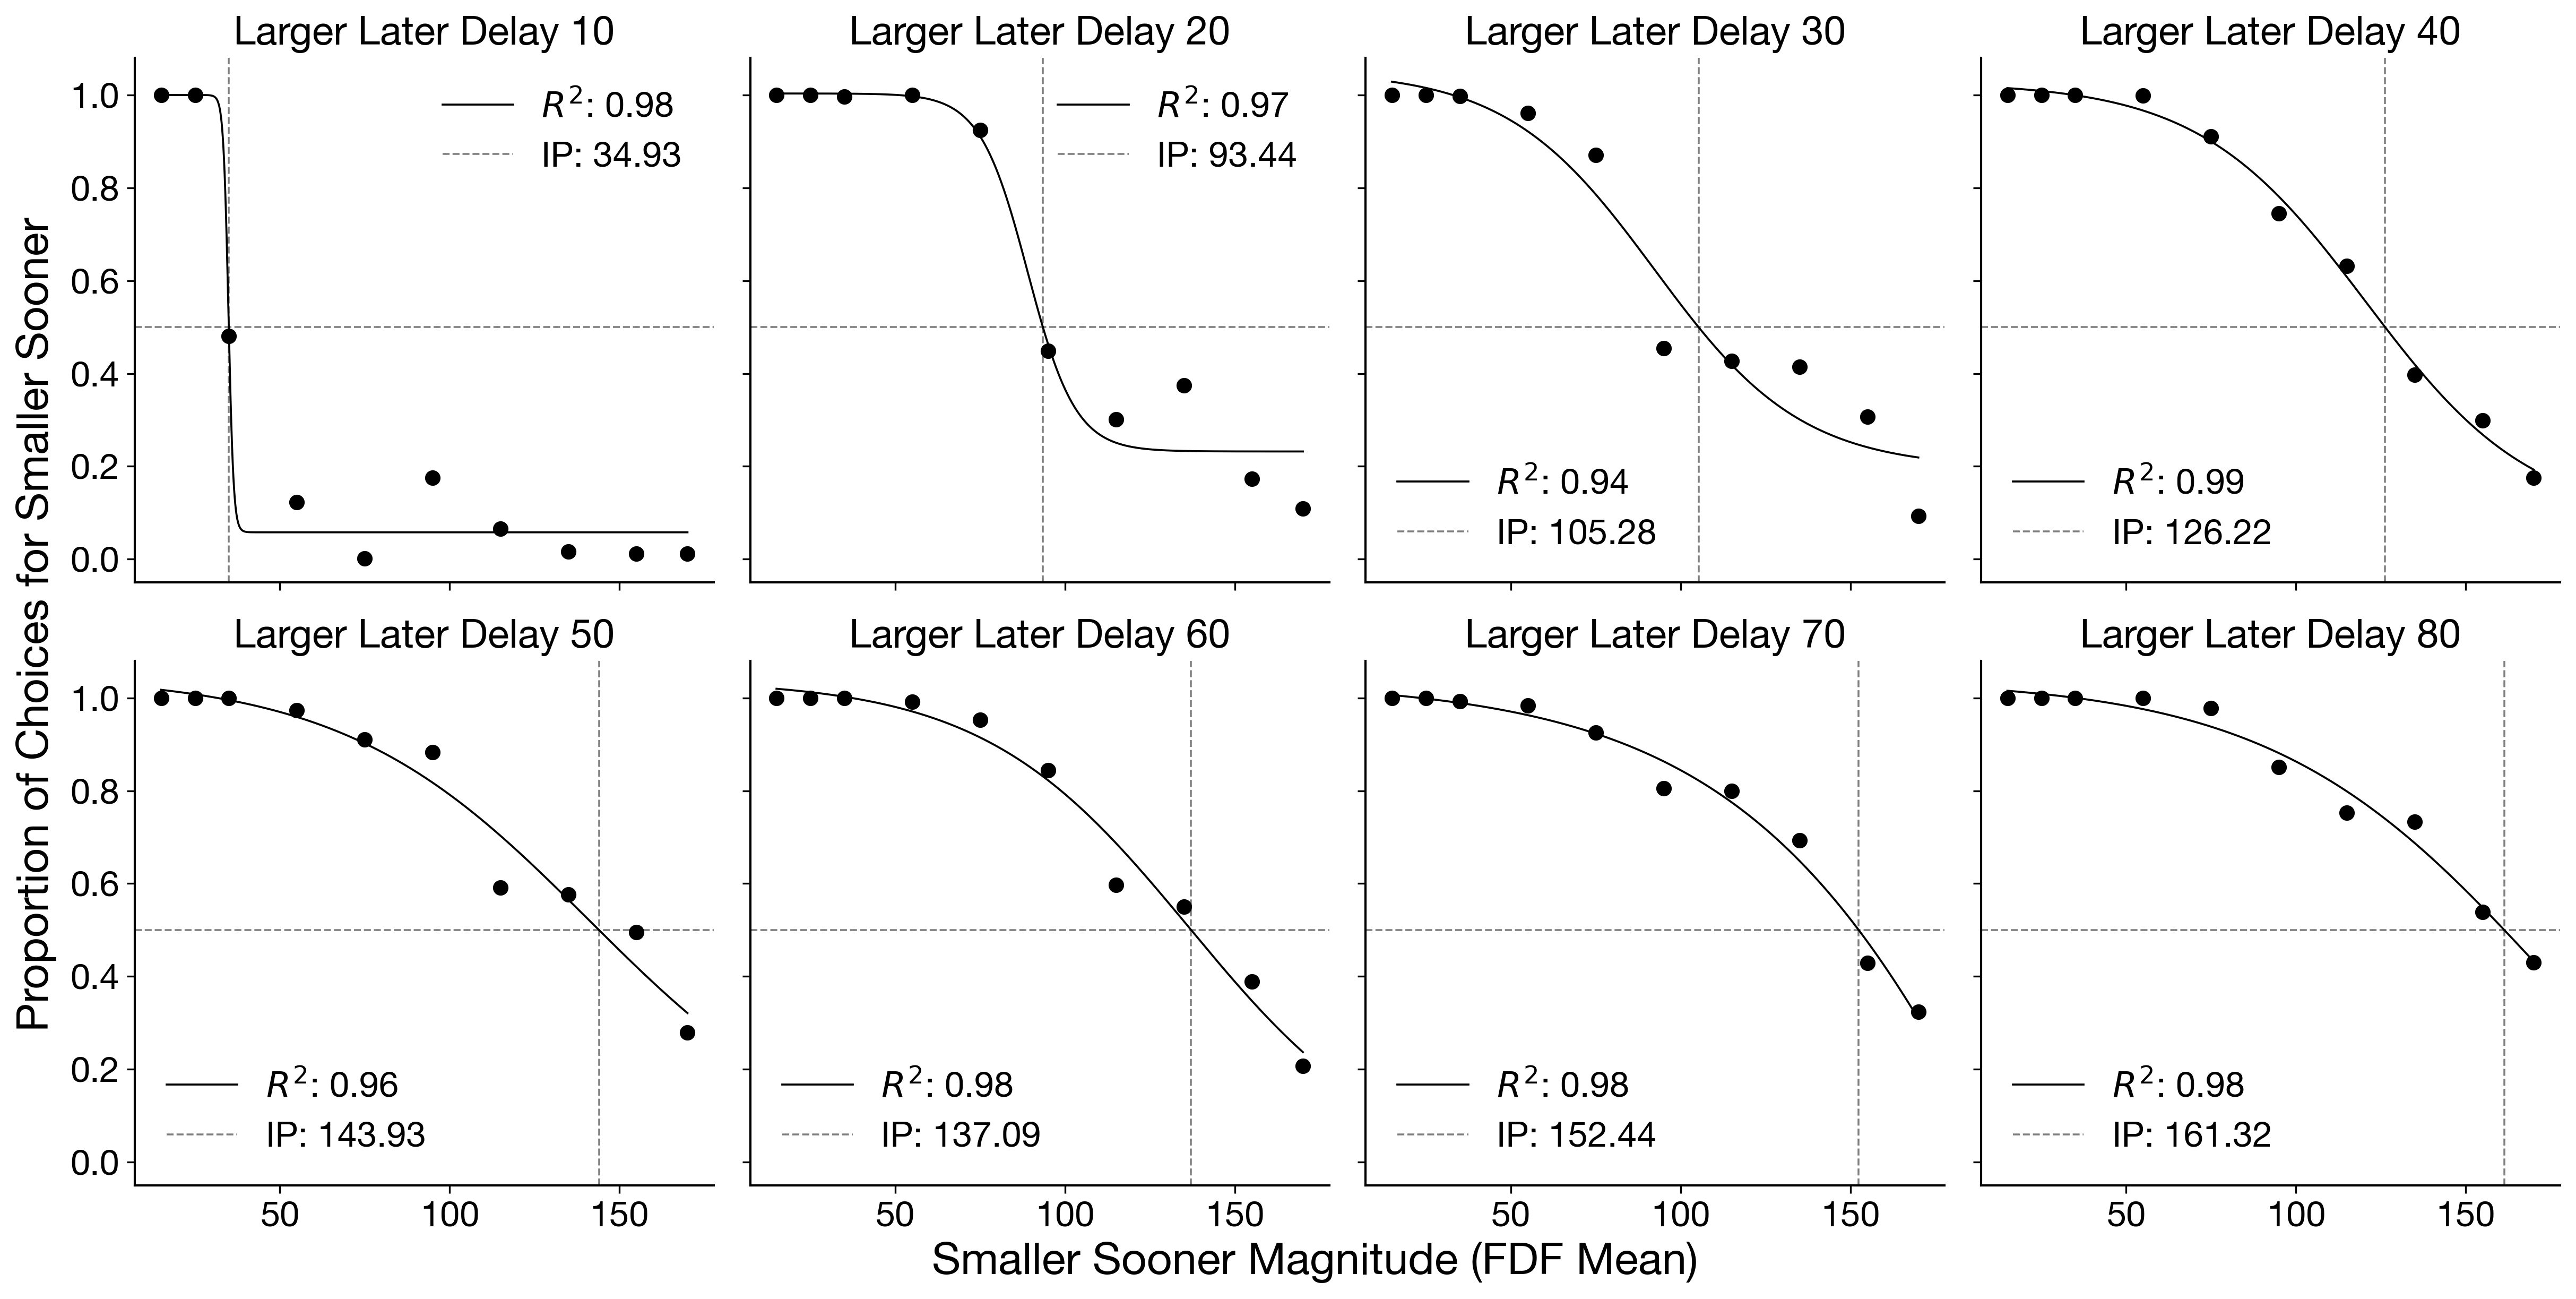

In [41]:
AO = 19

ao_df = ind_ao_df[ind_ao_df["Rep"] == AO]

fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, delay in enumerate(ao_df["LL Delay"].unique()):
    if delay == 5:
        continue # skip delay 5

    df = ao_df[ao_df["LL Delay"] == delay]
    ax = axs[i - 1]

    mags = df["SSMag"].values
    props = df["PropSS"].values

    params, _ = curve_fit(sigmoid, mags, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    res = props - sigmoid(mags, *params)
    ss_res = np.sum(res**2)
    ss_tot = np.sum((props - np.mean(props))**2)
    r2 = 1 - (ss_res/ss_tot)

    estimation_x = np.linspace(min(mags), max(mags), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_pt = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]

    ax.scatter(mags, props, color='black')
    ax.plot(estimation_x, estimation_y, label=f"$R^2$: {r2:.2f}", lw=0.9)
    ax.axhline(0.5, linestyle='--', lw=0.85, alpha=0.5)
    ax.axvline(indiff_pt, linestyle='--', lw=0.85, alpha=0.5, label=f"IP: {indiff_pt:.2f}")
    ax.set_title(f"Larger Later Delay {int(delay)}", size=18)
    ax.legend(fontsize=16)

fig.tight_layout()
fig.text(0.5, -0.01, "Smaller Sooner Magnitude (FDF Mean)", ha='center', size=20)
fig.text(-0.01, 0.5, "Proportion of Choices for Smaller Sooner", va='center', rotation='vertical', size=20)

plt.show()

## Discounting for One AO

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_7180/252976555.py:15: RuntimeWarning: invalid value encountered in power
  return A / (1 + k*x)**s


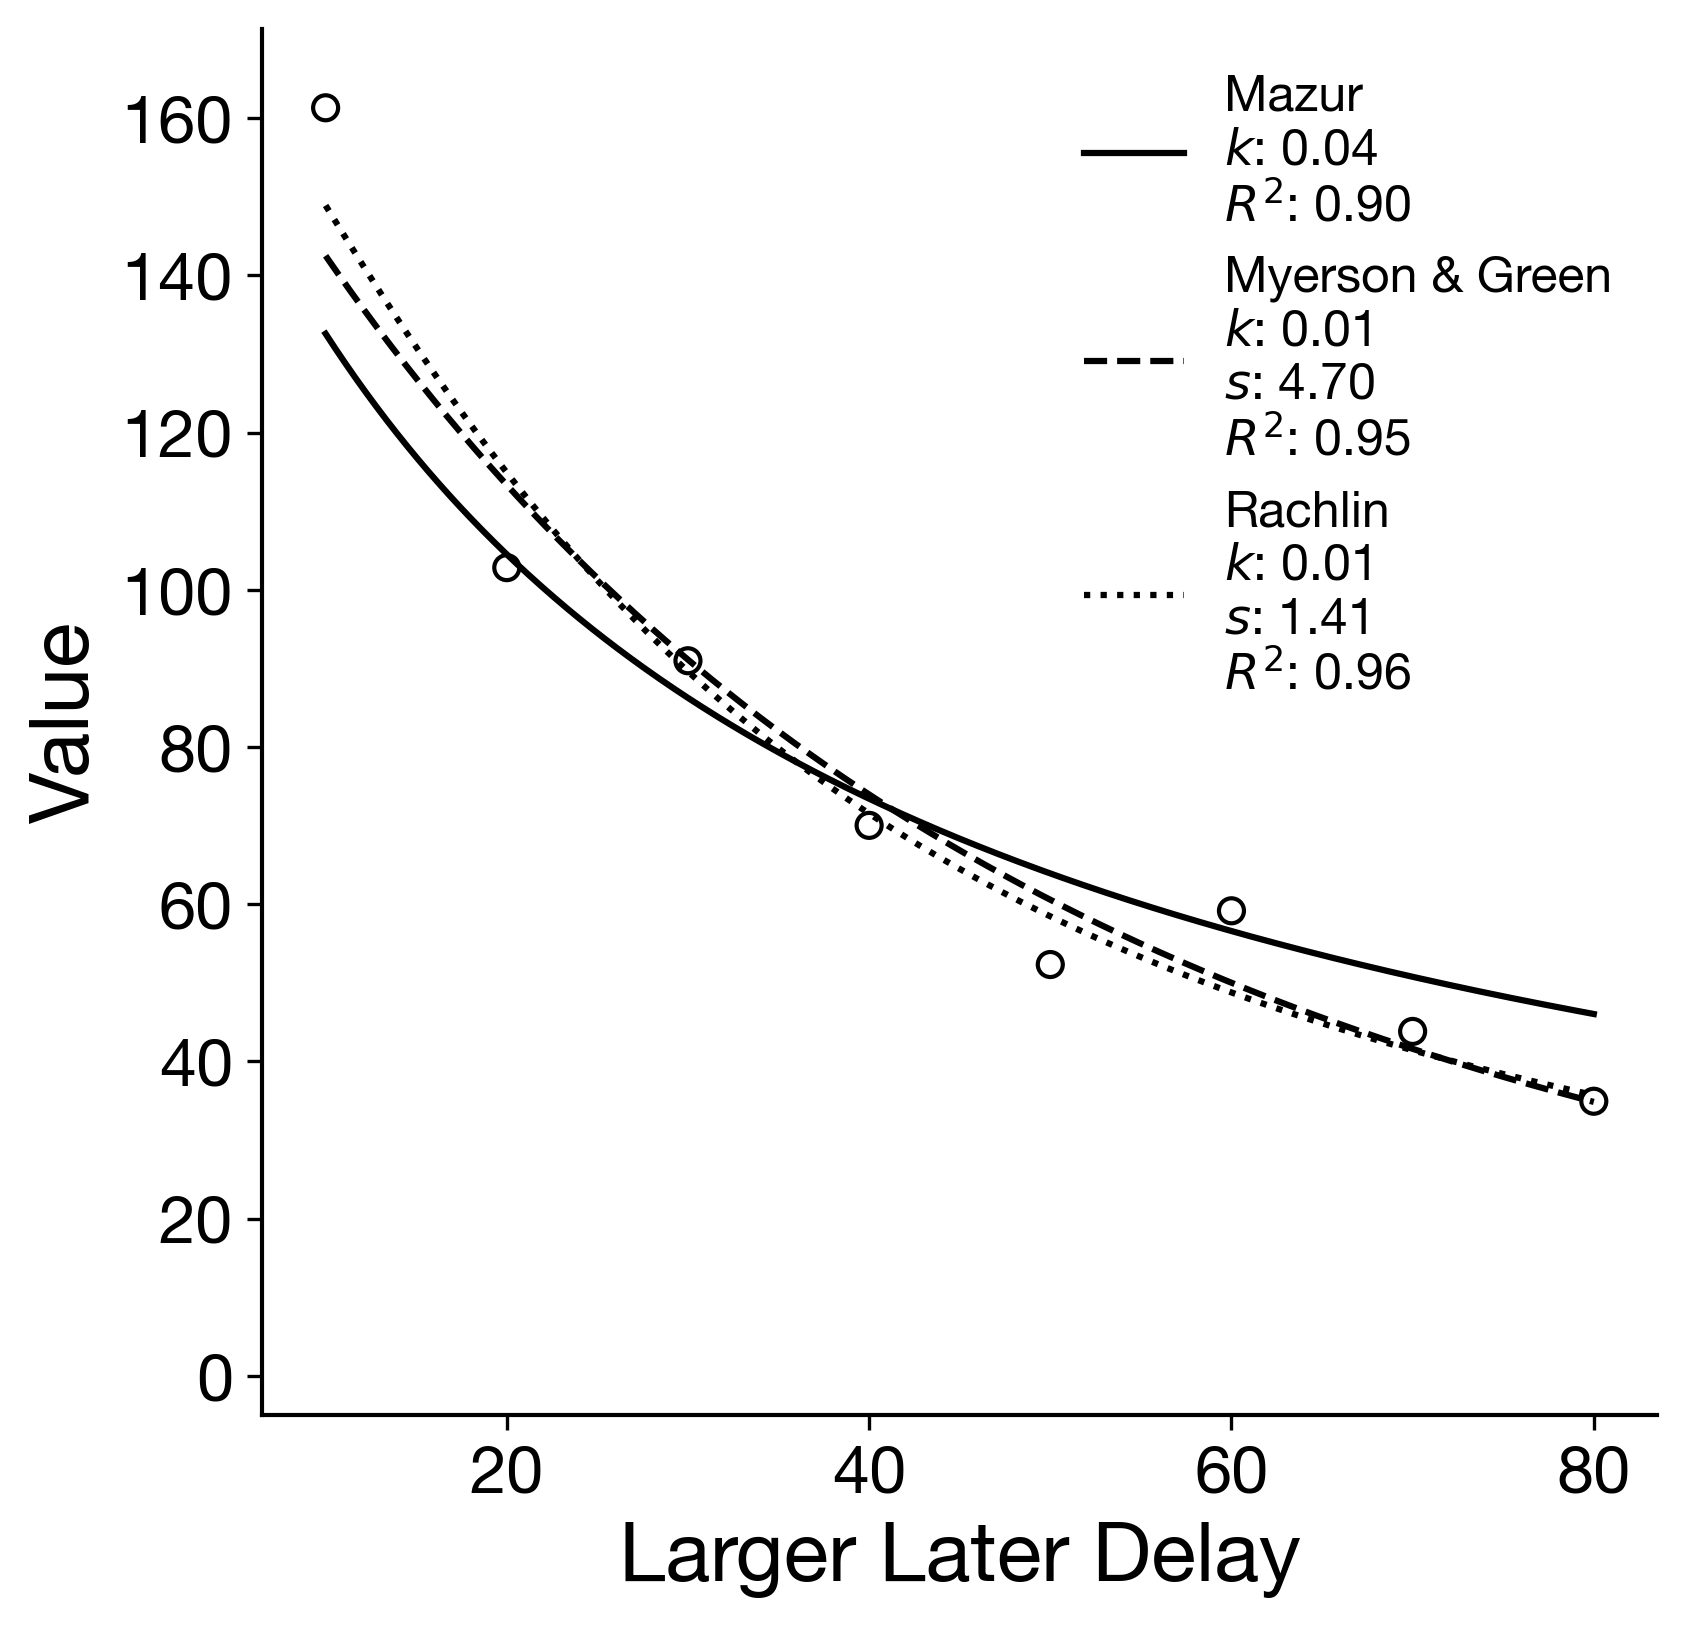

In [48]:
ao_df = ao_indiff_pts_df[ao_indiff_pts_df["Rep"] == AO]


x = ao_df["LL Delay"].values
y = ao_df["Transformed Indifference Point"].values
A = min(y) + max(y) - LL_MAG # set A for this AO

plotting_x = np.linspace(min(x), max(x), 1000)

ss_tot = np.sum((y - np.mean(y))**2)

# Mazur
mazur_params, _ = curve_fit(mazur, x, y, p0=[0.05], maxfev=10000)

mazur_res = y - mazur(x, *mazur_params)
mazur_ss_res = np.sum(mazur_res**2)
mazur_r2 = 1 - (mazur_ss_res/ss_tot)

# Myerson & Green
myerson_green_params, _ = curve_fit(myerson_green, x, y, p0=[0.05, 1], maxfev=10000)

myerson_green_res = y - myerson_green(x, *myerson_green_params)
myerson_green_ss_res = np.sum(myerson_green_res**2)
myerson_green_r2 = 1 - (myerson_green_ss_res/ss_tot)

# Rachlin
rachlin_params, _ = curve_fit(rachlin, x, y, p0=[0.05, 1], maxfev=10000)

rachlin_res = y - rachlin(x, *rachlin_params)
rachlin_ss_res = np.sum(rachlin_res**2)
rachlin_r2 = 1 - (rachlin_ss_res/ss_tot)

fig, ax = plt.subplots()

ax.scatter(x, y, facecolors='none', edgecolors='black')
ax.plot(plotting_x, mazur(plotting_x, *mazur_params), label=f"Mazur\n$k$: {mazur_params[0]:.2f}\n$R^2$: {mazur_r2:.2f}")
ax.plot(plotting_x, myerson_green(plotting_x, *myerson_green_params), label=f"Myerson & Green\n$k$: {myerson_green_params[0]:.2f}\n$s$: {myerson_green_params[1]:.2f}\n$R^2$: {myerson_green_r2:.2f}", linestyle='--', color='black')
ax.plot(plotting_x, rachlin(plotting_x, *rachlin_params), label=f"Rachlin\n$k$: {rachlin_params[0]:.2f}\n$s$: {rachlin_params[1]:.2f}\n$R^2$: {rachlin_r2:.2f}", linestyle=':', color='black')

ax.set_ylim(-5, max(y) + 10)
ax.set_xlabel("Larger Later Delay", size=20)
ax.set_ylabel("Value", size=20)
ax.legend()

plt.show()

## Indifference Point Estimation for Average Data

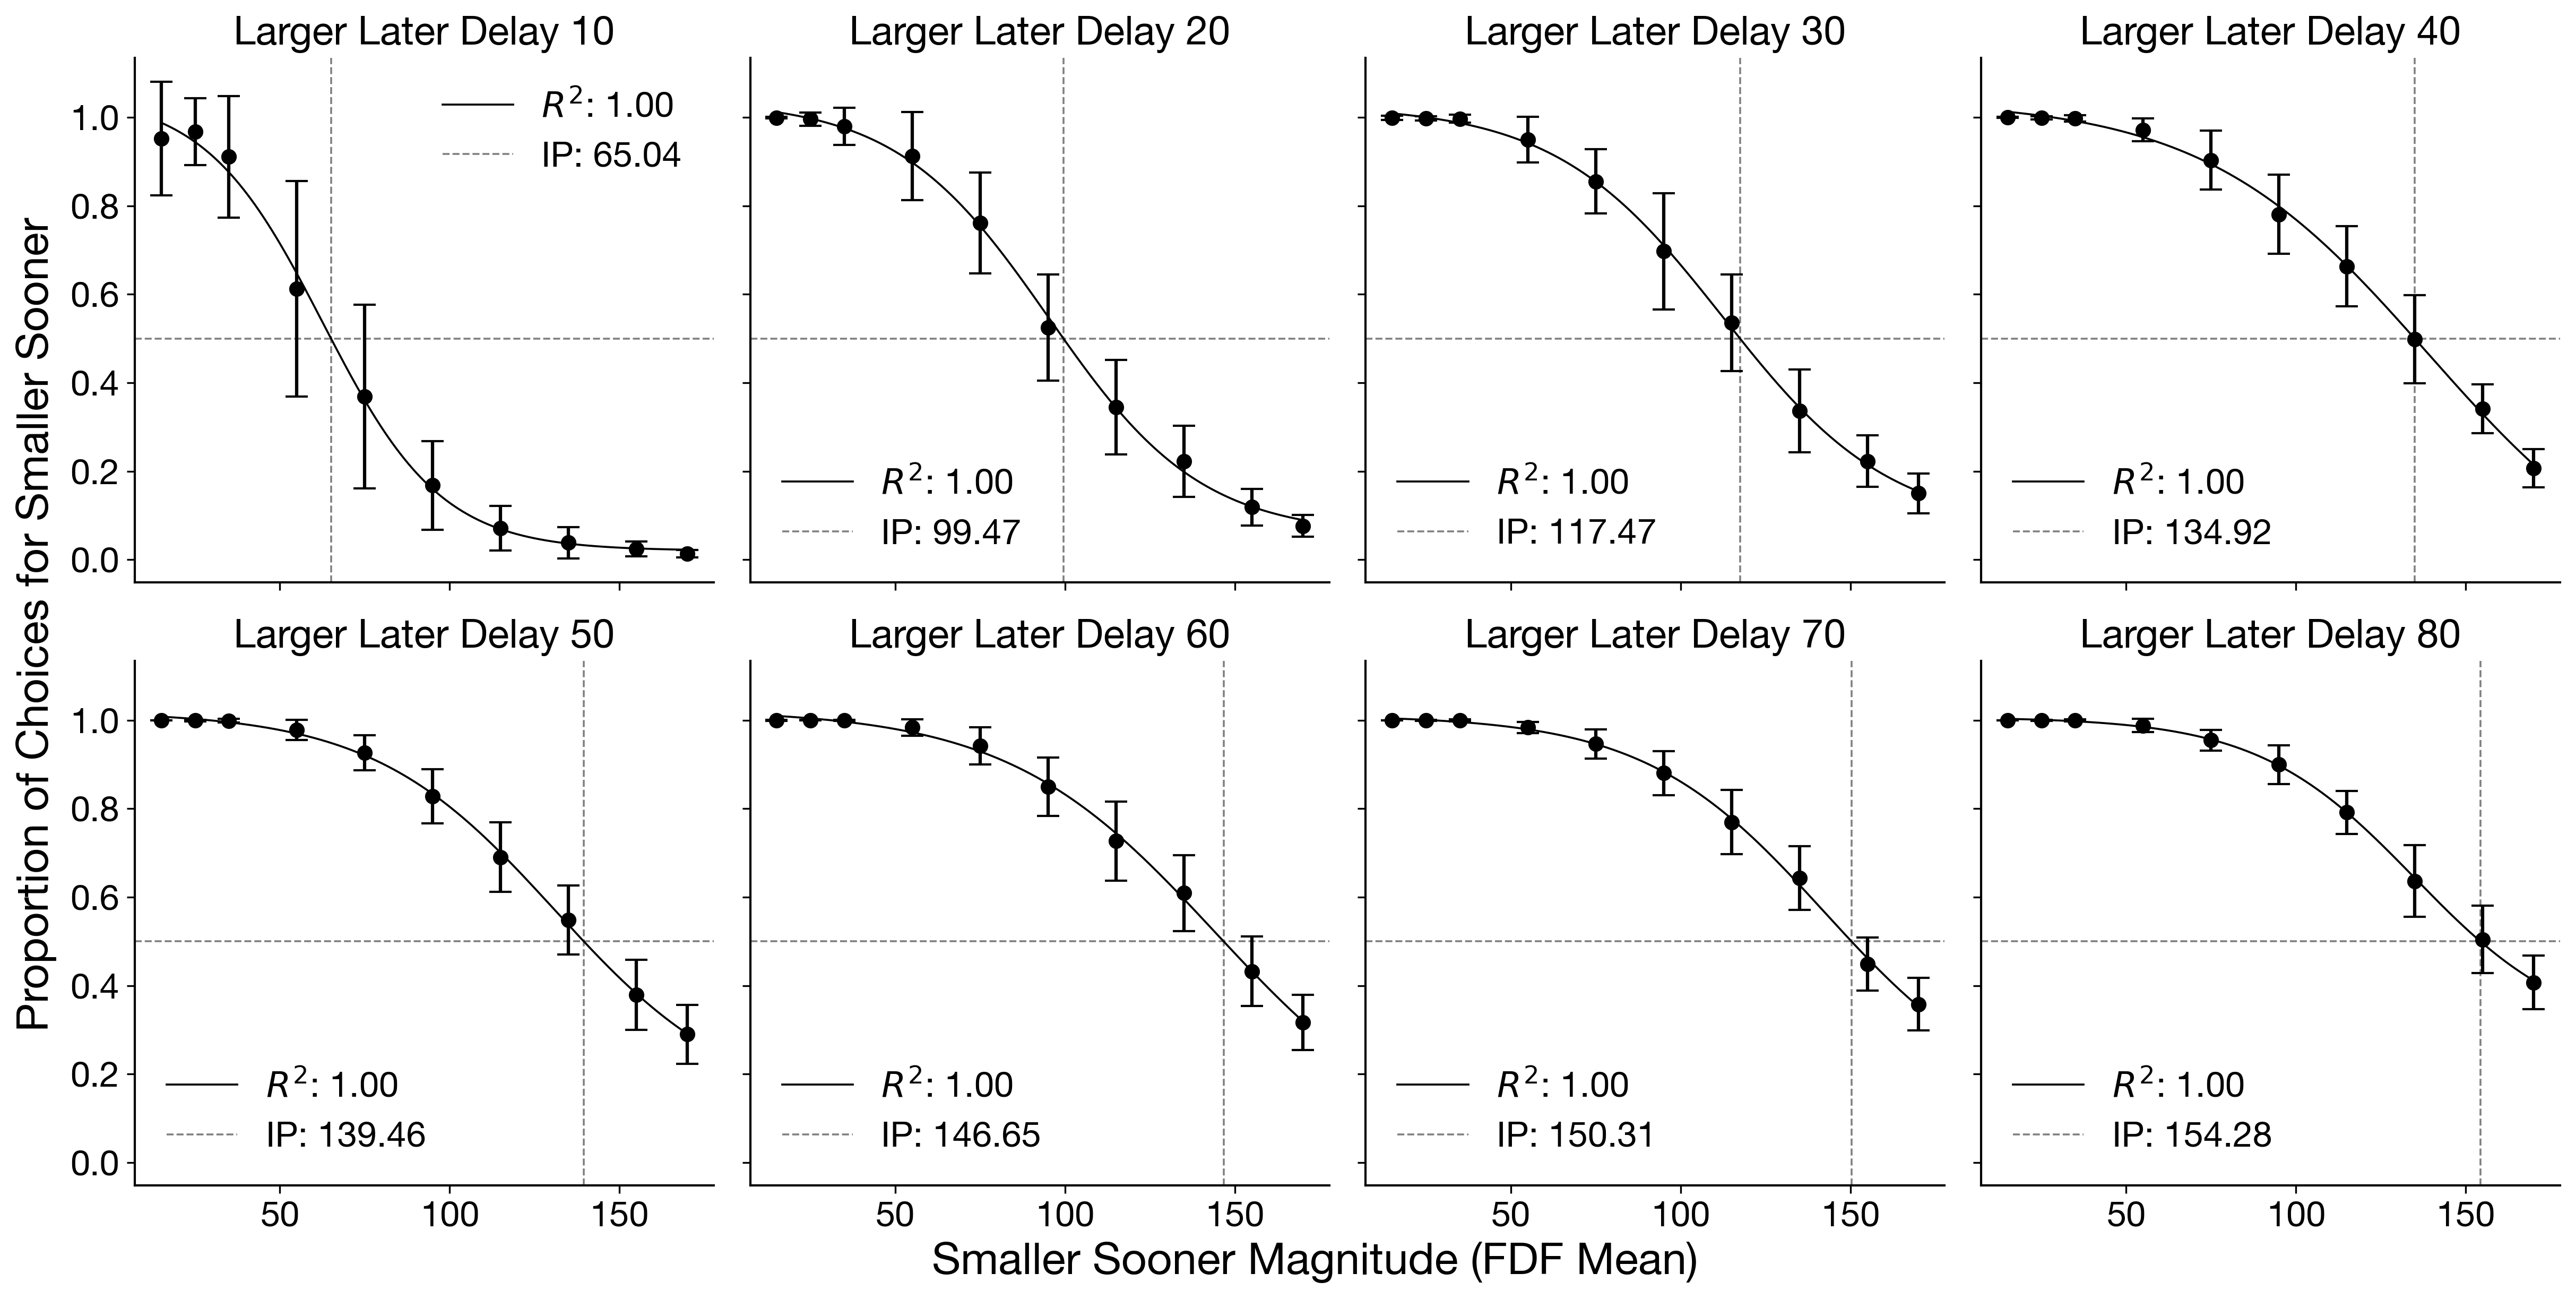

In [44]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.flatten()

avg_indiff_pts = []

for i, delay in enumerate(avg_df[("LL Delay", "mean")].unique()):
    if delay == 5:
        continue # skip delay 5

    df = avg_df[avg_df[("LL Delay", "mean")] == delay]
    ax = axs[i - 1]

    mags = df[("SSMag", "mean")].values
    props = df[("PropSS", "mean")].values
    props_err = df[("PropSS", "std")].values

    params, _ = curve_fit(sigmoid, mags, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    res = props - sigmoid(mags, *params)
    ss_res = np.sum(res**2)
    ss_tot = np.sum((props - np.mean(props))**2)
    r2 = 1 - (ss_res/ss_tot)

    estimation_x = np.linspace(min(mags), max(mags), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_pt = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]
    avg_indiff_pts.append(indiff_pt)

    ax.scatter(mags, props, color='black')
    ax.errorbar(mags, props, yerr=props_err, fmt='none', color='black', capsize=5)
    ax.plot(estimation_x, estimation_y, label=f"$R^2$: {r2:.2f}", lw=0.9)
    ax.axhline(0.5, linestyle='--', lw=0.85, alpha=0.5)
    ax.axvline(indiff_pt, linestyle='--', lw=0.85, alpha=0.5, label=f"IP: {indiff_pt:.2f}")
    ax.set_title(f"Larger Later Delay {int(delay)}", size=18)
    ax.legend(fontsize=16)

fig.tight_layout()
fig.text(0.5, -0.01, "Smaller Sooner Magnitude (FDF Mean)", ha='center', size=20)
fig.text(-0.01, 0.5, "Proportion of Choices for Smaller Sooner", va='center', rotation='vertical', size=20)

plt.show()

## Average Discounting

In [45]:
avg_discounting_df = pd.DataFrame({
    "LL Delay": [10, 20, 30, 40, 50, 60, 70, 80],
    "Indifference Point": avg_indiff_pts,
    "Transformed Indifference Point": min_max_transform(np.array(avg_indiff_pts))
})

avg_discounting_df

,LL Delay,Indifference Point,Transformed Indifference Point
0,10,65.039004,154.281428
1,20,99.467947,119.852485
2,30,117.465247,101.855186
3,40,134.919992,84.400440
4,50,139.461946,79.858486
5,60,146.654665,72.665767
6,70,150.313031,69.007401
7,80,154.281428,65.039004


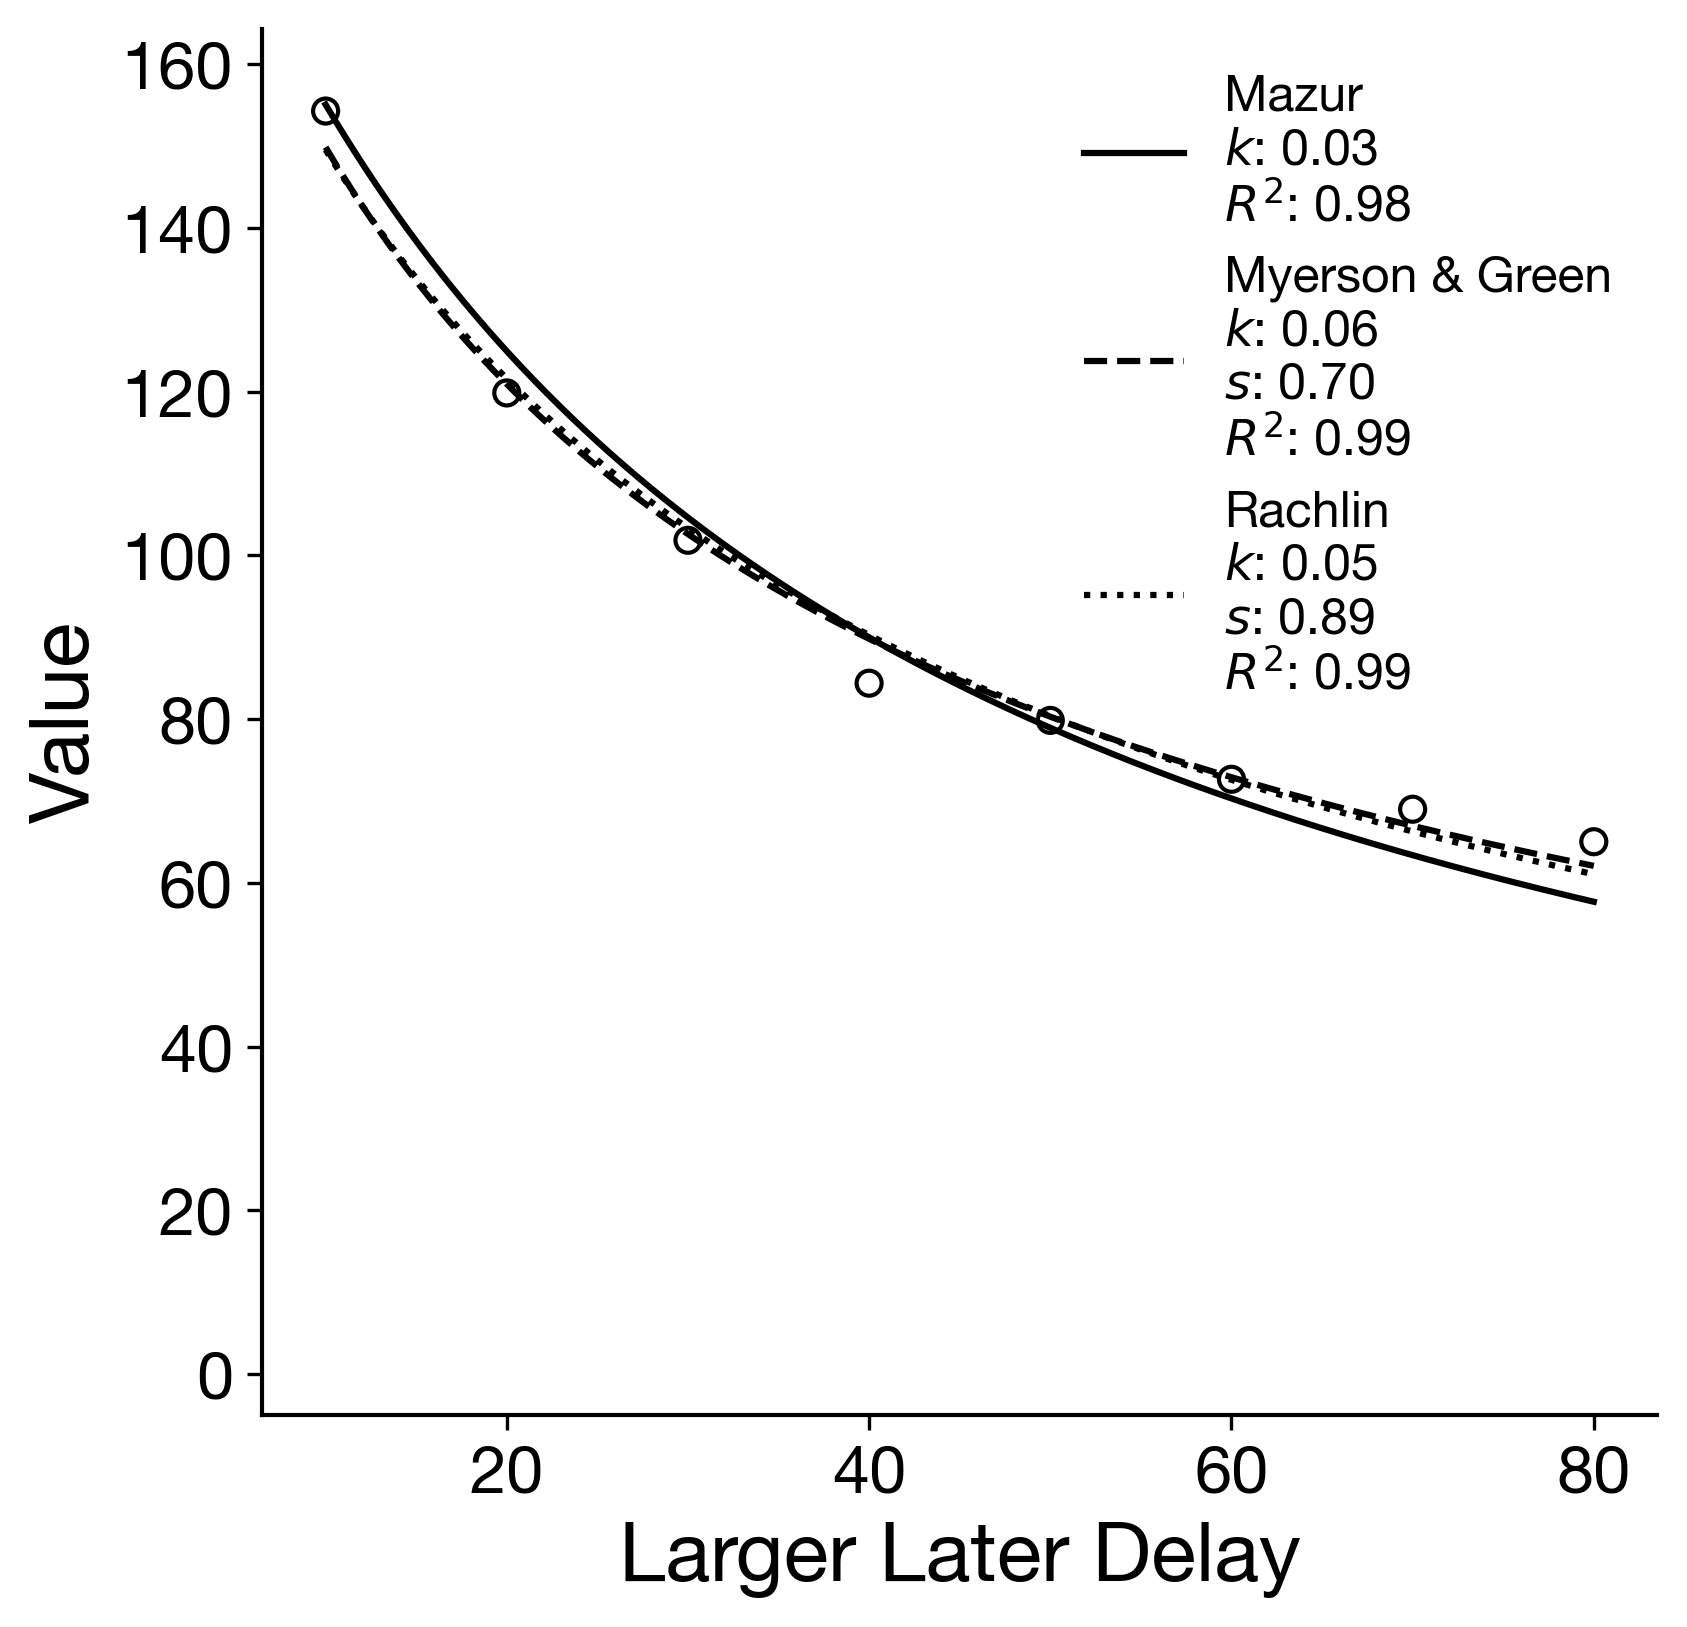

In [49]:
x = avg_discounting_df["LL Delay"].values
y = avg_discounting_df["Transformed Indifference Point"].values
A = min(y) + max(y) - LL_MAG # set A for the average data

plotting_x = np.linspace(min(x), max(x), 1000)

ss_tot = np.sum((y - np.mean(y))**2)

# Mazur
mazur_params, _ = curve_fit(mazur, x, y, p0=[0.05], maxfev=10000)

mazur_res = y - mazur(x, *mazur_params)
mazur_ss_res = np.sum(mazur_res**2)
mazur_r2 = 1 - (mazur_ss_res/ss_tot)

# Myerson & Green
myerson_green_params, _ = curve_fit(myerson_green, x, y, p0=[0.05, 1], maxfev=10000)

myerson_green_res = y - myerson_green(x, *myerson_green_params)
myerson_green_ss_res = np.sum(myerson_green_res**2)
myerson_green_r2 = 1 - (myerson_green_ss_res/ss_tot)

# Rachlin
rachlin_params, _ = curve_fit(rachlin, x, y, p0=[0.05, 1], maxfev=10000)

rachlin_res = y - rachlin(x, *rachlin_params)
rachlin_ss_res = np.sum(rachlin_res**2)
rachlin_r2 = 1 - (rachlin_ss_res/ss_tot)

fig, ax = plt.subplots()

ax.scatter(x, y, facecolors='none', edgecolors='black')
ax.plot(plotting_x, mazur(plotting_x, *mazur_params), label=f"Mazur\n$k$: {mazur_params[0]:.2f}\n$R^2$: {mazur_r2:.2f}")
ax.plot(plotting_x, myerson_green(plotting_x, *myerson_green_params), label=f"Myerson & Green\n$k$: {myerson_green_params[0]:.2f}\n$s$: {myerson_green_params[1]:.2f}\n$R^2$: {myerson_green_r2:.2f}", linestyle='--', color='black')
ax.plot(plotting_x, rachlin(plotting_x, *rachlin_params), label=f"Rachlin\n$k$: {rachlin_params[0]:.2f}\n$s$: {rachlin_params[1]:.2f}\n$R^2$: {rachlin_r2:.2f}", linestyle=':', color='black')

ax.set_ylim(-5, max(y) + 10)
ax.set_xlabel("Larger Later Delay", size=20)
ax.set_ylabel("Value", size=20)
ax.legend()

plt.show()

## Residuals

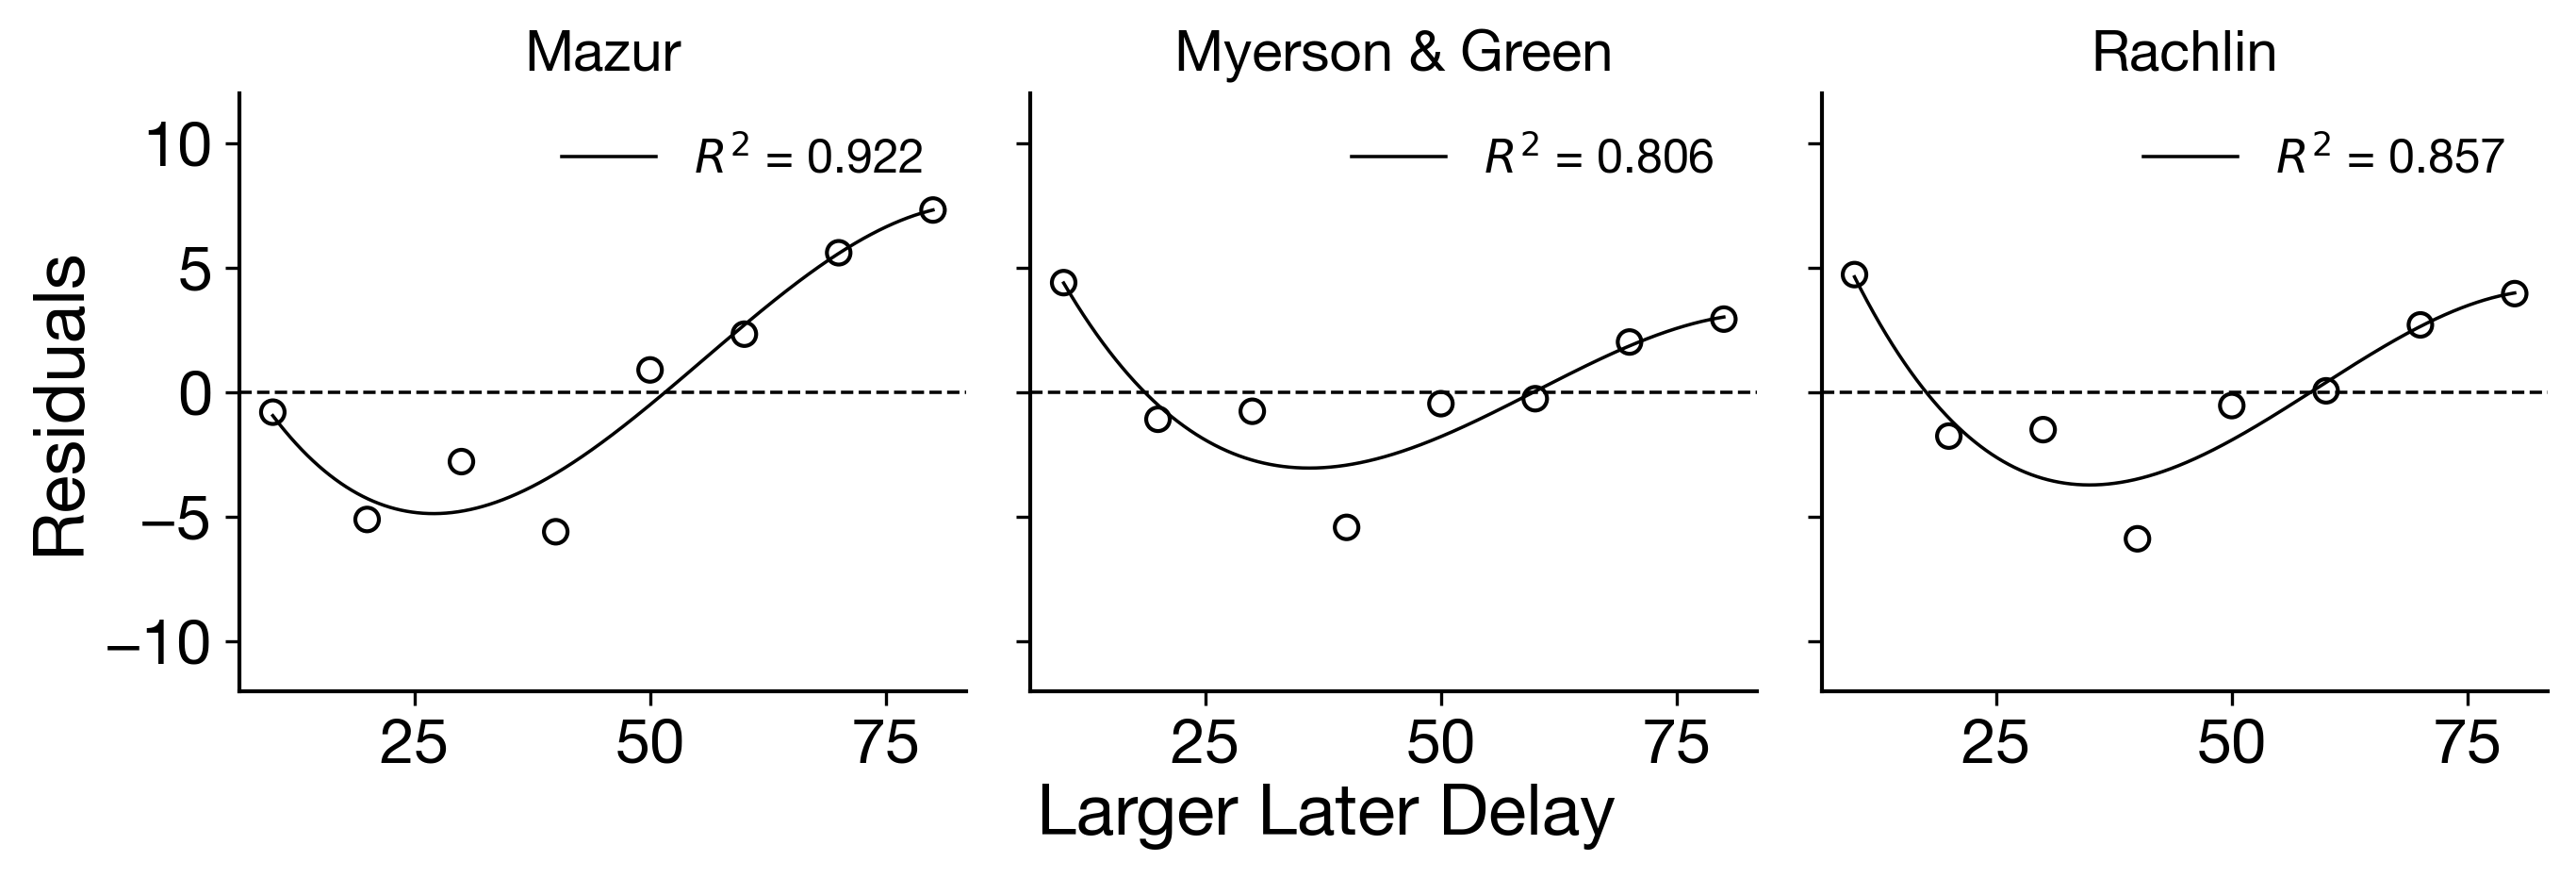

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

for i, res in enumerate([mazur_res, myerson_green_res, rachlin_res]):
    x = np.array(DELAYS[1:]) # ignore delay 5
    y = np.array(res)

    popt, _ = curve_fit(cubic, x, y, p0=[0.05, 0.05, 0.05, 0.05], maxfev=10000)

    res = y - cubic(x, *popt)
    ss_res = np.sum(res**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)

    plotting_x = np.linspace(min(x), max(x), 10000)
    plotting_y = cubic(plotting_x, *popt)

    axs[i].scatter(x, y, marker='o', facecolors='none', edgecolors='k')
    axs[i].plot(plotting_x, plotting_y, label=f'$R^2$ = {r2:.3f}', linewidth=0.85)
    axs[i].set_title(['Mazur', 'Myerson & Green', 'Rachlin' ][i])
    axs[i].legend()
    axs[i].axhline(0, color='k', linestyle='--', linewidth=0.85)
    axs[i].set_ylim(-12, 12)
    axs[i].set_yticks([-10, -5, 0, 5, 10])
    

fig.text(0.5, -0.01, 'Larger Later Delay', ha='center', fontsize=18)
fig.text(-0.01, 0.5, 'Residuals', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
plt.show()

# LL 5 Removal

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_7180/2979780213.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted([int(mag) for mag in data['SSMag'].unique()]))
/Users/ryanhigginbotham/anaconda3/envs/dataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryanhigginbotham/anaconda3/envs/dataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ryanhigginbotham/anaconda3/envs/dataAnalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-lik

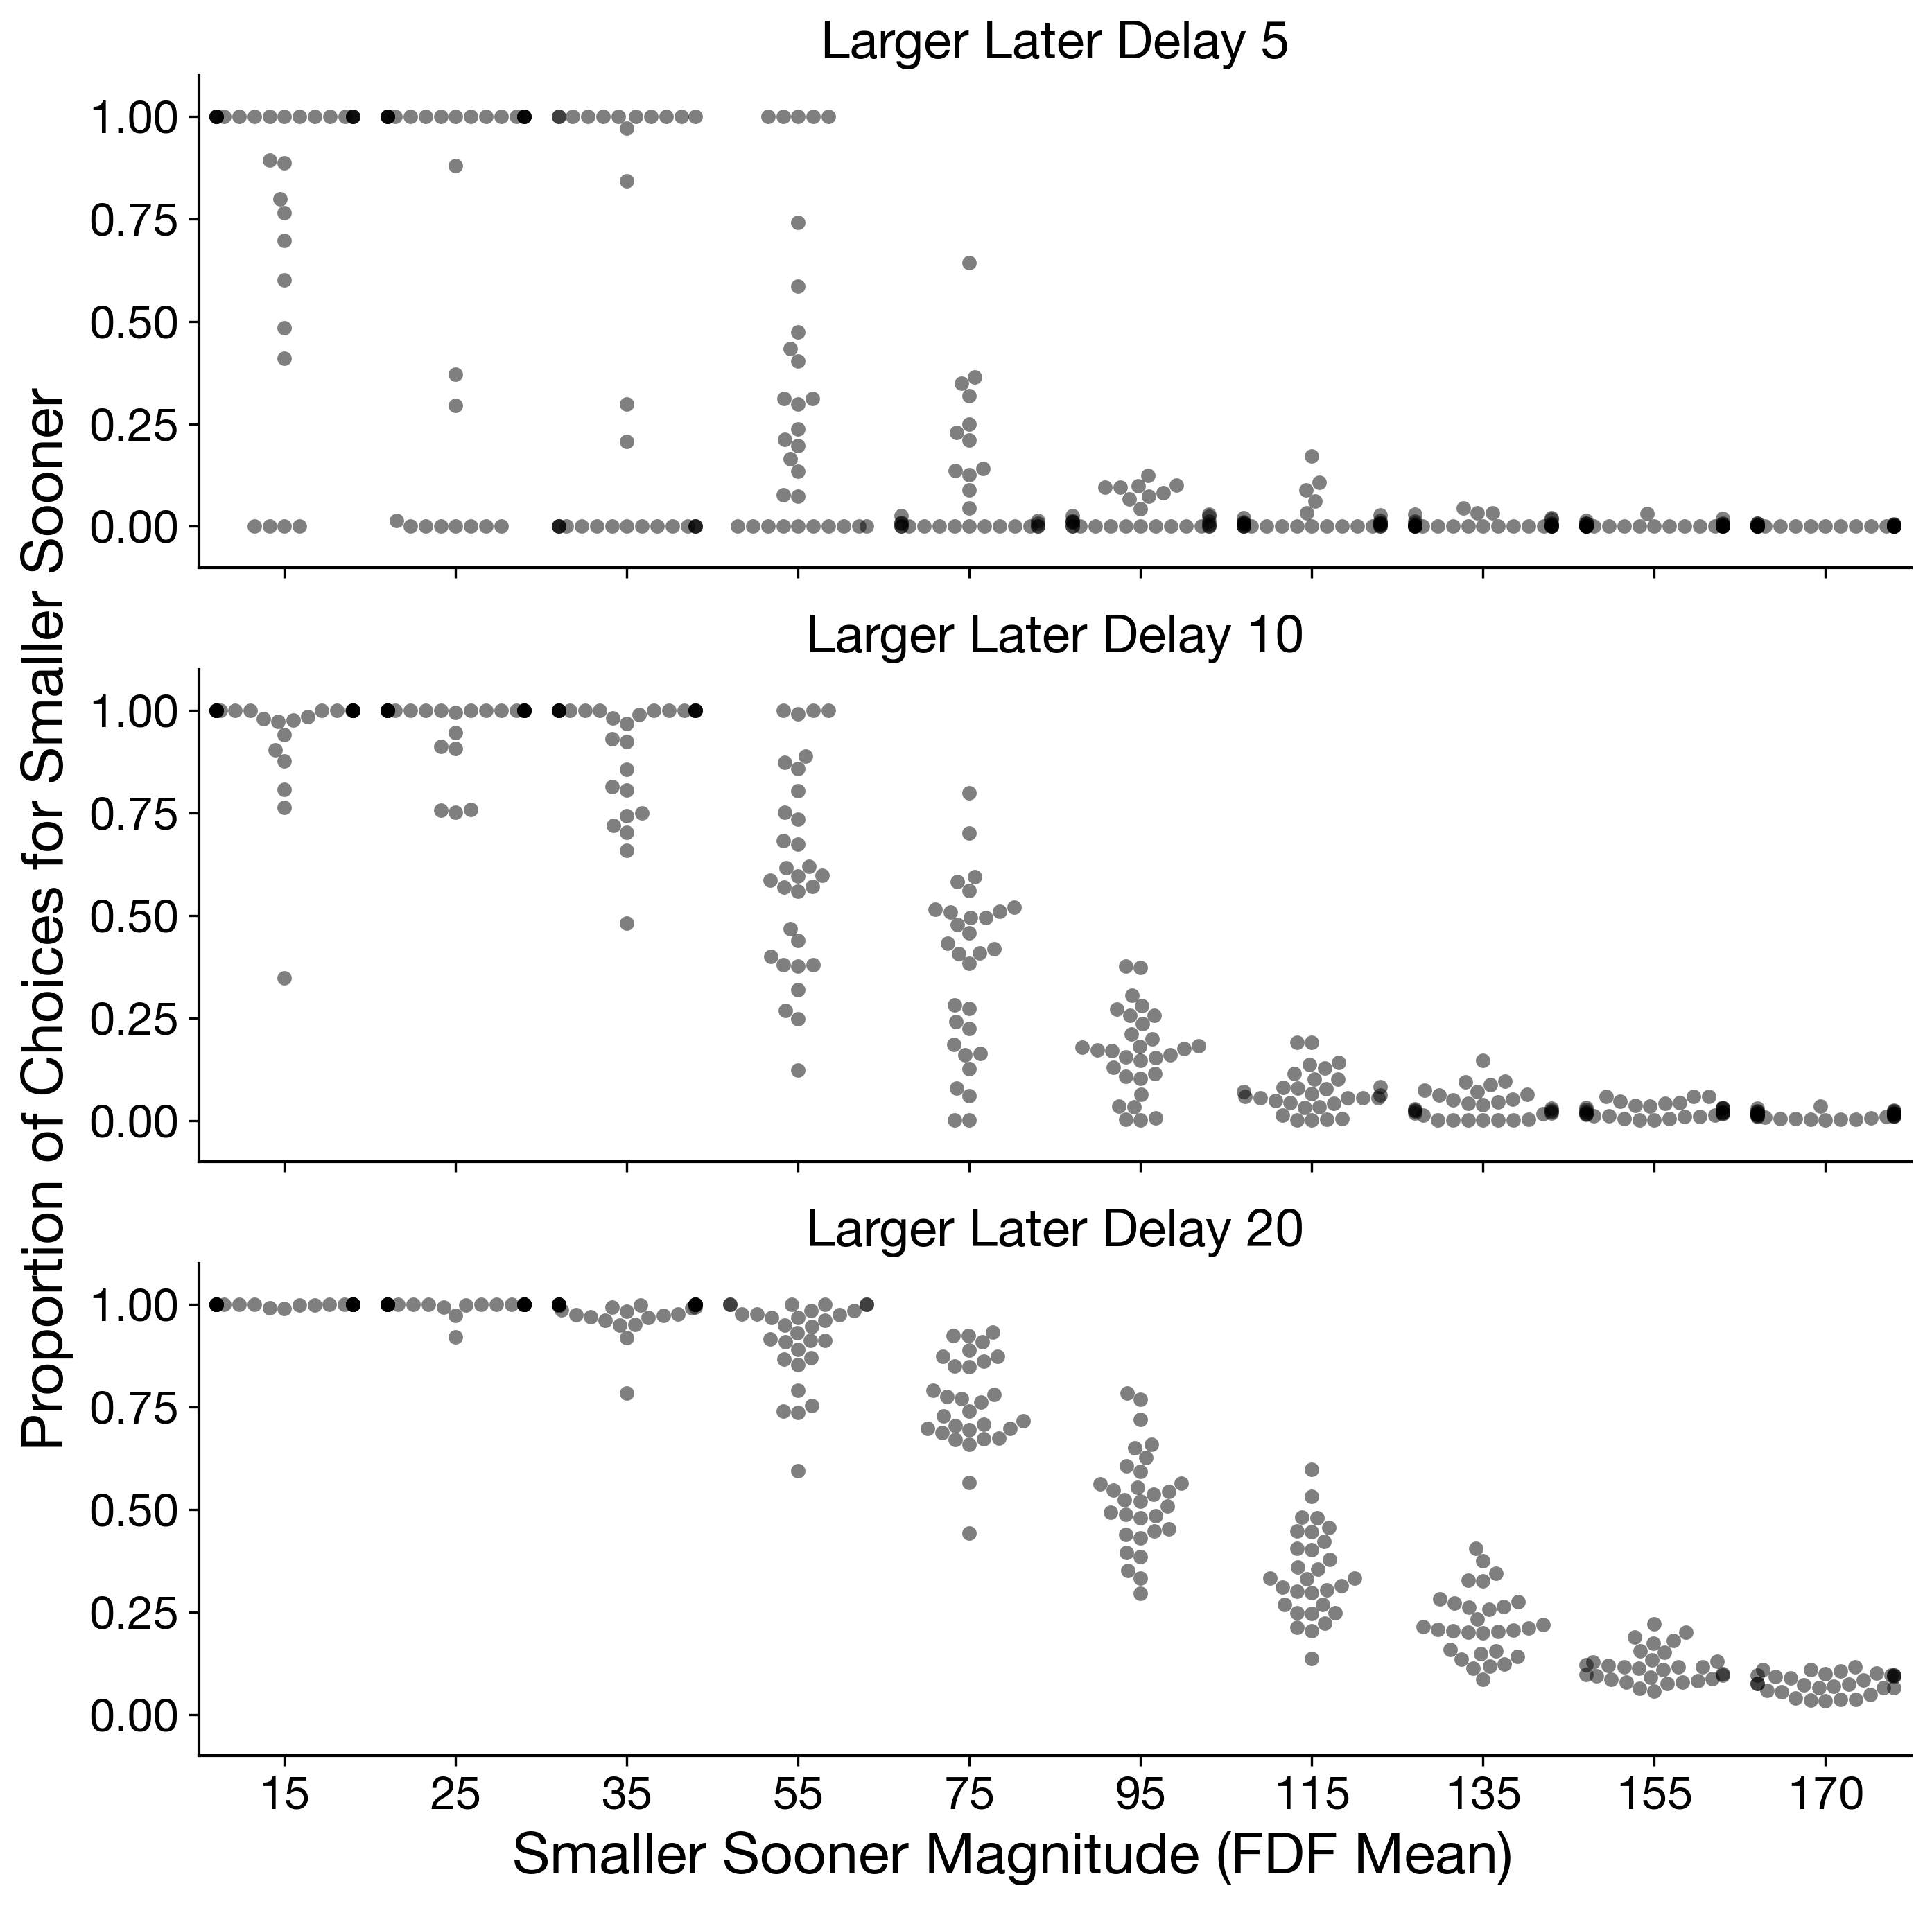

In [61]:
fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

for i, ll_delay in enumerate(ind_ao_df['LL Delay'].unique()):
    if i > 2:
        break
    data = ind_ao_df[ind_ao_df['LL Delay'] == ll_delay]

    ax = axs[i]

    ax.set_title(f'Larger Later Delay {int(ll_delay)}', fontsize=18)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticklabels(sorted([int(mag) for mag in data['SSMag'].unique()]))


    sns.swarmplot(data=data, x='SSMag', y='PropSS', ax=ax, color='k', alpha=0.5)

    ax.set_xlabel('')
    ax.set_ylabel('')

fig.text(0.5, -0.01, 'Smaller Sooner Magnitude (FDF Mean)', ha='center', fontsize=20)
fig.text(-0.03, 0.5, 'Proportion of Choices for Smaller Sooner', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.show()